<a href="https://colab.research.google.com/github/StefanHubner/MachineLearningEconomics/blob/main/LogitNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This takes about 9-10 minutes

Sys.setenv("CUDA" = "cpu")
Sys.setenv("TORCH_INSTALL" = "1")
install.packages("torch", reinstall = FALSE)
torch::install_torch()

library(torch)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘coro’




In [2]:
install.packages("IRdisplay") # for displaying stuff in a notebook
library(IRdisplay)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
install.packages("ISLR") # for the dataset
library(ISLR)

data("Default")
Default$default1 <- as.double(Default$default == "Yes")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



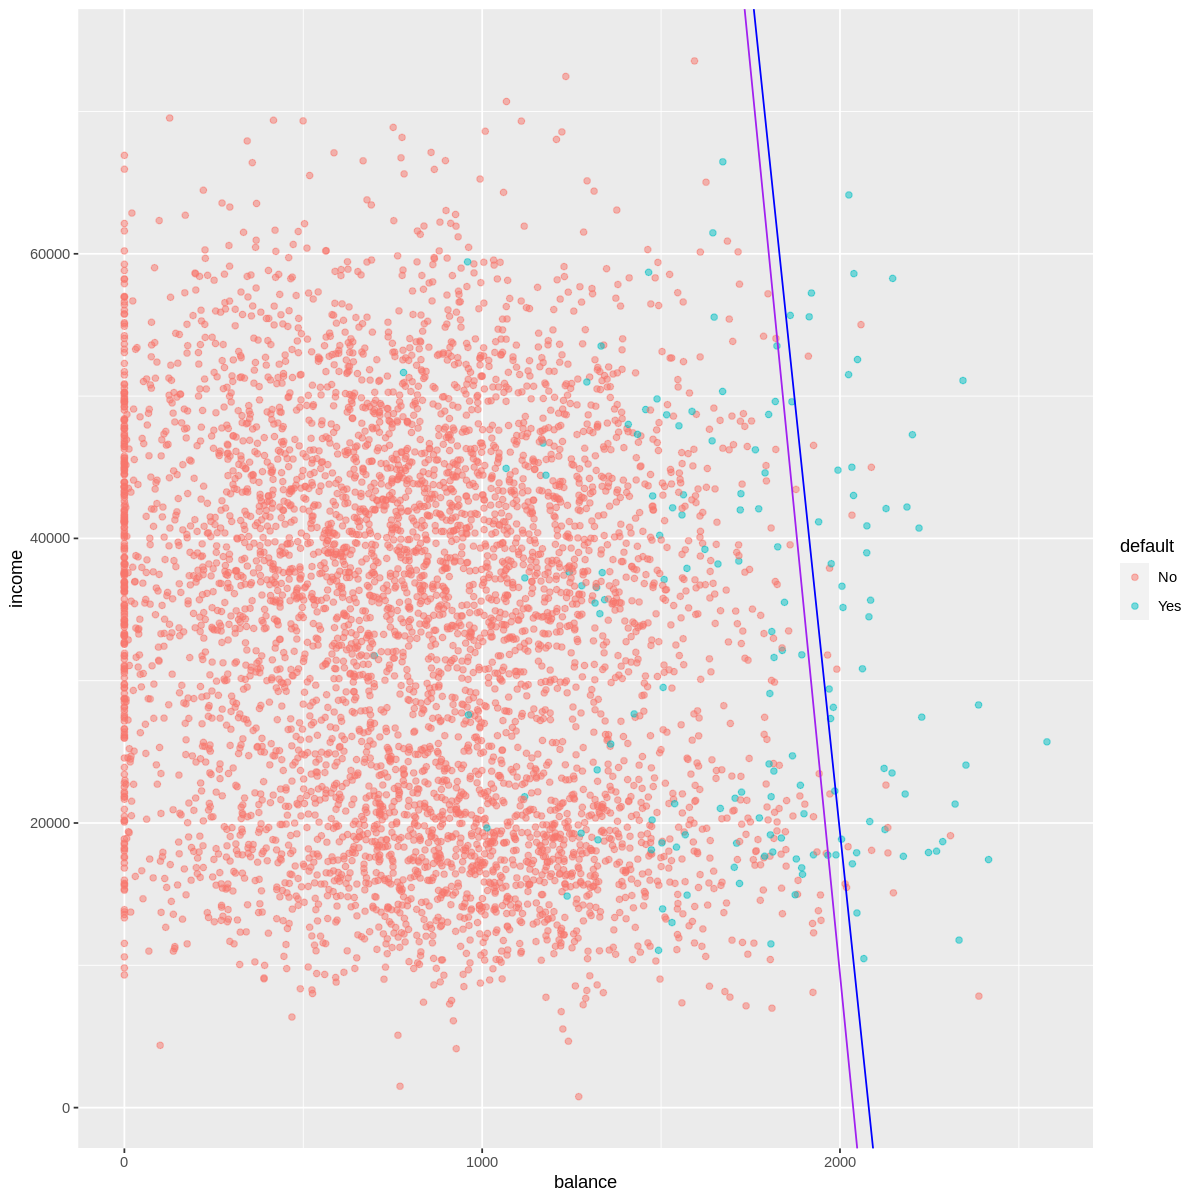

In [9]:
library(ggplot2)

options(repr.plot.width = 10, repr.plot.height = 10)

n <- nrow(Default)
traini <- sample(1:n, n/2)
testi <- -traini

train <- Default[traini,]

# From Logit estimation in Classification Chapter
blogit <- c(-11.1437010201259, 0.0053562007038889, 2.22954252823084e-05)

# From Autograd/Logit estimation (balance and income normalised to 1000s)
bag <- c(-11.9398772178039, 5.86175377227419 * .001, 0.0230383165130453 * .001)

p0 <- ggplot(Default[testi,], aes(y = income, x = balance, color = default)) +
        geom_point(alpha = 0.5) +
        geom_abline(intercept = -blogit[1]/blogit[3], slope = -blogit[2]/blogit[3], color = "blue") +
        geom_abline(intercept = -bag[1]/bag[3], slope = -bag[2]/bag[3], color = "purple")

p0

In [15]:
# The "modern" way

x1x2 <- cbind(1, as.matrix(train[,c("balance", "income")])/1000)
y1 <- train$default1

y <- torch_tensor(y1, requires_grad = TRUE)
x <- torch_tensor(x1x2[,-1], requires_grad = TRUE) # no intercept, "bias" is explicit


# Define single-layer neural network (logistic regression)
model <- nn_module(
  "LogitModel",
  initialize = function(input_dim, output_dim) {
    self$linear <- nn_linear(input_dim, output_dim)
  },
  forward = function(x) {
    x %>% self$linear() %>% nnf_sigmoid()
  }
)

# Initialize model and optimizer
input_dim <- x$size()[2]
output_dim <- 1

net <- model(input_dim, output_dim)
optimizer <- optim_adam(net$parameters)

# Training settings
epochs <- 50000
loss_function <- nn_bce_loss() # binary cross entropy

# Training loop
for(epoch in 1:epochs) {
  optimizer$zero_grad()
  output <- net(x)
  loss <- loss_function(output$squeeze(), y)
  loss$backward()
  optimizer$step()
  if (epoch %% (epochs / 50) == 0) # print a total of intermediate 50 steps
    display_html(sprintf("<tt>%d: %f</tt>", epoch, as.numeric(loss$detach())))
}

# View the learned parameters
print("Learned parameters:")
print(net$linear$weight)
print(net$linear$bias)

[1] 5000

[1] 5000    2

1000: 0.185930

2000: 0.179963

3000: 0.171092

4000: 0.159766

5000: 0.147078

6000: 0.134564

7000: 0.123413

8000: 0.114081

9000: 0.106548

10000: 0.100601

11000: 0.095986

12000: 0.092468

13000: 0.089843

14000: 0.087942

15000: 0.086623

16000: 0.085767

17000: 0.085265

18000: 0.085018

19000: 0.084928

20000: 0.084909

21000: 0.084907

22000: 0.084908

23000: 0.084907

24000: 0.084907

25000: 0.084907

26000: 0.084907

27000: 0.084907

28000: 0.084907

29000: 0.084907

30000: 0.084907

31000: 0.084907

32000: 0.084907

33000: 0.084907

34000: 0.084907

35000: 0.084907

36000: 0.084907

37000: 0.084908

38000: 0.084907

39000: 0.084907

40000: 0.084907

41000: 0.084907

42000: 0.084907

43000: 0.084907

44000: 0.084907

45000: 0.084907

46000: 0.084907

47000: 0.084907

48000: 0.084907

49000: 0.084907

50000: 0.084907

[1] "Learned parameters:"
torch_tensor
 5.6406  0.0174
[ CPUFloatType{1,2} ][ requires_grad = TRUE ]
torch_tensor
-11.3253
[ CPUFloatType{1} ][ requires_grad = TRUE ]


In [17]:
# we have normalised X to 1000s of USD (currency)
bnn <- c(as.numeric(net$linear$bias$detach()), .001*as.numeric(net$linear$weight$detach()))

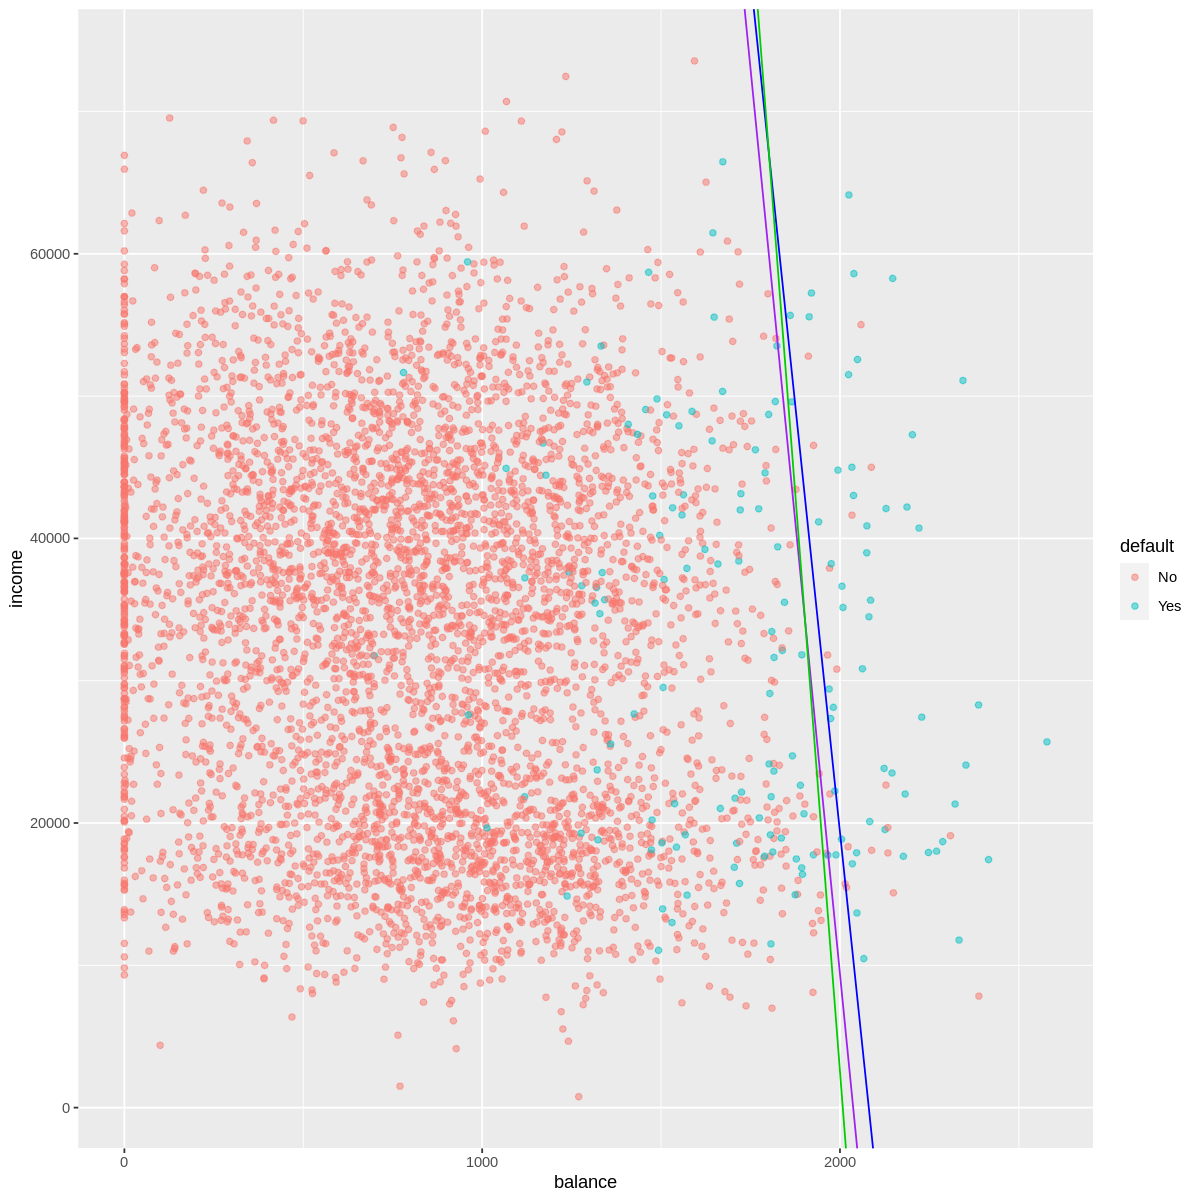

In [22]:
p0 + geom_abline(intercept = -bnn[1]/bnn[3], slope = -bnn[2]/bnn[3], color = "green3")